## Модель предсказания среднего балла по математике

В данном ноутбуке реализована модель предсказания среднего балла по математике на основе данных о подготавливающем к экзамену репетиторе. Модель построена на алгоритме random forest. Предсказание балла производится на основе среднего значения по предсказаниям всех деревьев в ансамбле.

### 1. Описание датасета

**Таргет:**

**mean_exam_points** - средний балл по математике

**Независимые характеристики:**
- **id** - идентификационный номер репетитора
- **age** - возраст репетитора
- **years_of_experience** - количество лет практики
- **lesson_price** - стоимость занятия
- **qualification** - уровень квалификации
- **physics** - репетитор преподает физику
- **chemistry** - репетитор преподает физику химию
- **biology** - репетитор преподает биологию
- **english** - репетитор преподает английский язык
- **geography** - репетитор преподает географию
- **history** - репетитор преподает историю

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection

### 2. Подготовка и изучение данных

In [2]:
path_train = 'train.csv'
path_test = 'test.csv'

df = pd.read_csv(path_train)
df.head(2)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0


In [3]:
X = df.drop('mean_exam_points', axis=1)
X.set_index('Id', inplace=True)

X_final = pd.read_csv(path_test)
X_final.set_index('Id', inplace=True)


y = df[['mean_exam_points']]

In [4]:
target_mean = y['mean_exam_points'].mean()
target_median = y['mean_exam_points'].median()

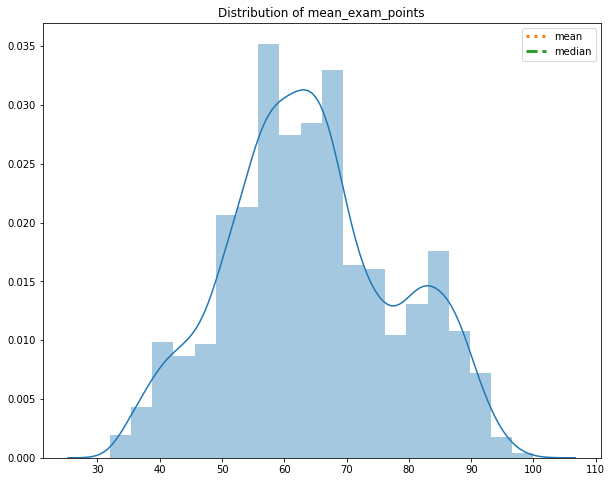

Skewness: 0.15353785505136924
Kurtosis: -0.5463508059580886


In [5]:
plt.figure(figsize = (10, 8))
sns.distplot(y, bins=20)

n = np.linspace(0, 0.000007, 100)
plt.plot([target_mean] * 100, n, label='mean', linestyle=':', linewidth=3)
plt.plot([target_median] * 100, n, label='median', linestyle='--', linewidth=3)


plt.title('Distribution of mean_exam_points')
plt.legend()
plt.show()
print(f'Skewness: {y.skew()[0]}')
print(f'Kurtosis: {y.kurt()[0]}')

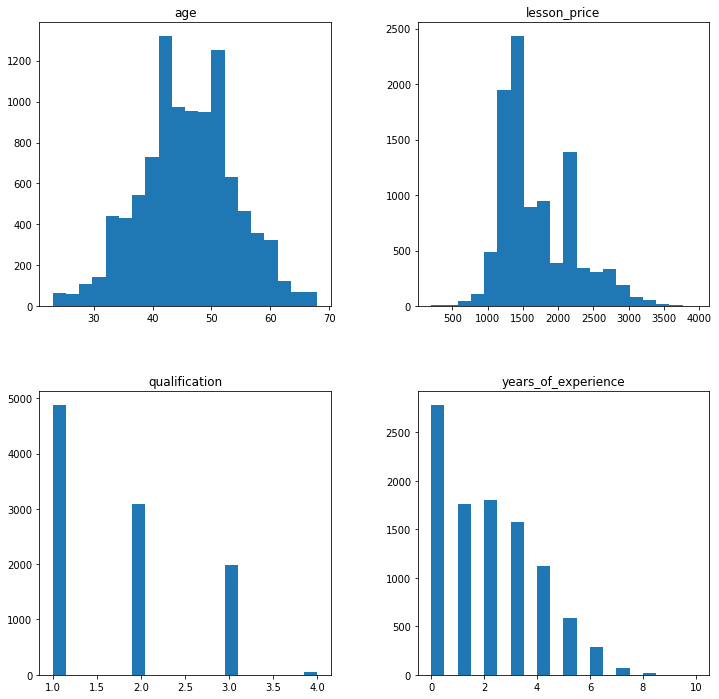

In [6]:
X_num_features = ['age', 'years_of_experience', 'lesson_price', 'qualification']

X[X_num_features].hist(figsize=(12,12), bins=20, grid=False)
plt.show()

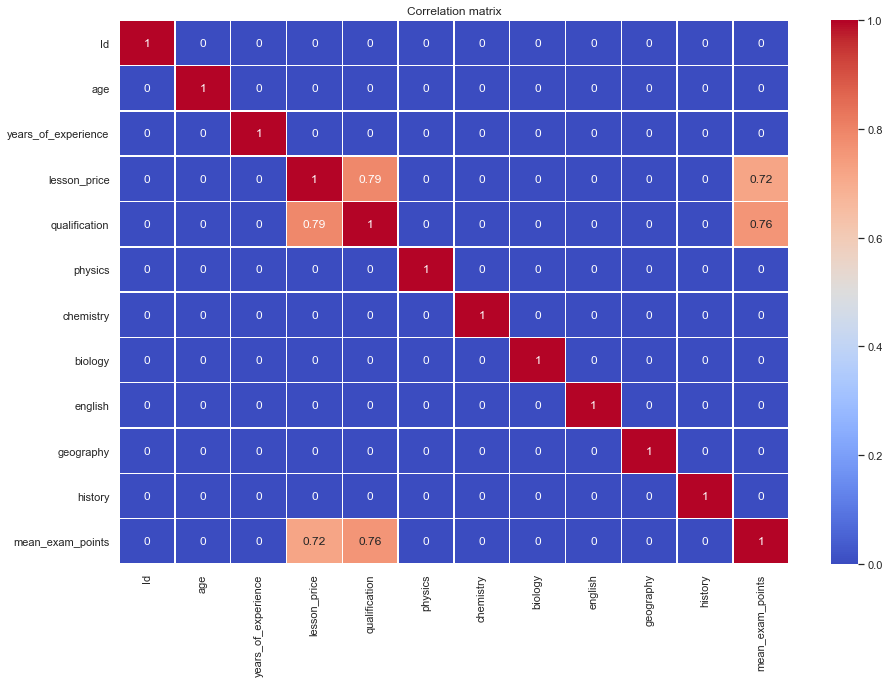

In [7]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1)

df_corr = pd.read_csv(path_train)
corr_matrix = df_corr.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Наибольшая корреляция балла наблюдается от признаков цена за урок и уровень квалификации преподавателя.

### 3. Очистка данных

In [8]:
class FeatureImputer:
    """Обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
            
    def transform(self, X):
        
        X.loc[X['qualification'] > 3, 'qualification'] = self.medians['qualification']

        return X

In [9]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

### 4. Генерация фич

In [10]:
class FeatureGenetator():
    """Генерация новых фич"""

        
    def fit(self, X, y):
        df = X.copy()
        
        
        df['mean_exam_points'] = y.values
        
        
        self.med_exam_points_by_qualification = df.groupby(['qualification']) \
            .agg({'mean_exam_points':'median'}) \
            .rename(columns={'mean_exam_points':'MedExam_pointsByQual'})
        
        self.med_exam_points_by_years_of_exp = df.groupby(['years_of_experience']) \
            .agg({'mean_exam_points':'mean'}) \
            .rename(columns={'mean_exam_points':'MedExam_pointsByYears_of_exp'})
        
        
        df = self.lesson_to_cat(df) 
        self.med_exam_points_by_lesson_price = df.groupby(['lesson_cat']) \
            .agg({'mean_exam_points':'mean'}) \
            .rename(columns={'mean_exam_points':'MedExam_pointsByLesson_price'})
        

        
    def transform(self, X):
        
        X = self.lesson_to_cat(X)
        
        X = X.merge(self.med_exam_points_by_qualification, on=['qualification'], how='left')
        X = X.merge(self.med_exam_points_by_lesson_price, on=['lesson_cat'], how='left')
        X = X.merge(self.med_exam_points_by_years_of_exp, on=['years_of_experience'], how='left')
        
        
        return X
        
    @staticmethod
    def lesson_to_cat(X):
        
        X['lesson_cat'] = np.nan
        
        X.loc[X['lesson_price'] < 1300, 'lesson_cat'] = 1  
        X.loc[(X['lesson_price'] >= 1300) & (X['lesson_price'] <= 1500), 'lesson_cat'] = 2
        X.loc[(X['lesson_price'] > 1500) & (X['lesson_price'] <= 2000), 'lesson_cat'] = 3
        X.loc[(X['lesson_price'] > 2000) & (X['lesson_price'] <= 3000), 'lesson_cat'] = 4
        X.loc[X['lesson_price'] > 3000, 'lesson_cat'] = 5   
        return X


In [11]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [12]:
remain_features = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics', 'chemistry',
                   'biology', 'english', 'geography', 'history',
                   
                   
                   'MedExam_pointsByQual','MedExam_pointsByLesson_price', 'MedExam_pointsByYears_of_exp']

X = X[remain_features]
X_final = X_final[remain_features]

### 4. Создание и обучение модели

In [13]:
X = X.to_numpy()
X_final = X_final.to_numpy()
y = y.T.to_numpy()[0]

In [14]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
class Leaf:
    
    def __init__(self, data, labels, data_type):
        self.data = data
        self.labels = labels
        self.prediction = self.predict(data_type)
        
    def predict(self, data_type):
        
        if data_type == 'objects':  
            # подсчет количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1

            return max(classes, key=classes.get)
            
        elif data_type == 'numbers':
            return np.mean(self.labels)
        
        
random.seed(42)

def get_bootstrap(data, labels, N):
    """Создание bootstrap-выборок, по которым будут обучатья деревья
    
    returns: список выборок и словарь, сдержащий использованные и 
    не использованные индексы
    
    """
    n_samples = data.shape[0]
    bootstrap = []
    used_idx = set()
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            used_idx.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
    
    oob_idx = set(range(0, n_samples)) - used_idx

    return bootstrap, {"oob": list(oob_idx), "used": list(used_idx)}


# выбор признаков для выборок
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample


def build_tree(data, labels, criterion_type, data_type, depth_limit=8, leaf_limit=200):

    quality, t, index = find_best_split(data, labels, criterion_type)

    # прекращаем рекурсию
    if quality == 0 or depth_limit == 0 or leaf_limit==1:
        return Leaf(data, labels, data_type), leaf_limit-1


    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    false_branch, leaf_limit = build_tree(false_data, false_labels, criterion_type, data_type, depth_limit-1, leaf_limit-1)
    true_branch, leaf_limit = build_tree(true_data, true_labels, criterion_type, data_type, depth_limit-1, leaf_limit+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), leaf_limit


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения
def find_best_split(data, labels, criterion_type):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1
    
    if criterion_type == 'gini':
        current_criterion = gini(labels)
    elif criterion_type == 'entropy':
        current_criterion = entropy(labels)
    elif criterion_type == 'variance':
        current_criterion = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion_type)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity


def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * np.log2(p)

    return entropy


def variance(data):
    return np.var(data) 


def quality(left_labels, right_labels, current_criterion, criterion_type):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    if criterion_type == 'gini':
        return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)
    elif criterion_type == 'entropy':
        return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    elif criterion_type == 'variance':
        return current_criterion - p * variance(left_labels) - (1 - p) * variance(right_labels)


def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

def random_forest(data, labels, n_trees, criterion_type, data_type, depth_limit, leaf_limit):
    forest = []
    bootstrap, indexes = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, criterion_type, data_type, depth_limit, leaf_limit))
        
    return forest, indexes

# предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree[0]))
    
    # сформируем список с предсказаниями для каждого объекта

    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(sum(obj)/len(obj))
        
    return voted_predictions

### 5. Кросс-валидация

In [15]:
def r2(y, y_pred):
    return 1 - np.var(y - y_pred) / np.var(y)

In [16]:
random_states = [1, 253, 45, 1234, 56]
r2s = []

In [17]:
for item in random_states:
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = item)
    my_forest, indexes = random_forest(X_train, y_train, n_trees=50, data_type='numbers', criterion_type='variance', depth_limit=10, leaf_limit=1000)

    test_answers = tree_vote(my_forest, X_test)
    r2s.append(r2(y_test, test_answers))
        
print(r2s)

[0.765607208571535, 0.7768849251164609, 0.7621370874015538, 0.7611228756527723, 0.7508386328338761]


## 6. Предсказание

In [18]:
y_pred_final = tree_vote(my_forest, X_final)

In [19]:
X_final = pd.read_csv(path_test)

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()


preds_final['mean_exam_points'] = y_pred_final
preds_final.head()

,Id,mean_exam_points
0,10000,55.075488
1,10001,63.227035
2,10002,48.522738
3,10003,89.493426
4,10004,88.532465


In [20]:
preds_final.to_csv('predictions.csv', index=False)